# Route Optimization
### MSDS 460 Final Project, Summer 2022, Group 1
#### Author: Sarah Rodenbeck
#### Version: August 8, 2022

### Required Packages

In [259]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import approximation
import momepy
from scipy import spatial
import xml.etree.ElementTree as ET
from sqlalchemy import create_engine, text
from sqlalchemy_utils import create_database, database_exists, drop_database
import osmnx as ox
import folium
from sklearn import cluster
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore')

### Create Graph

In [243]:
ox.config(use_cache=True, log_console=True)

#Define Bounding Box
north, east, south, west = 41.8, -87.5240, 41.75, -87.6

#Create OX Graph and Project
Gox = ox.graph_from_bbox(north, south, east, west, network_type="drive")

proj_Gox = ox.project_graph(Gox)

#GeoDataFrames
Gox_gdf = ox.graph_to_gdfs(Gox)
Gox_gdf = Gox_gdf[0].reset_index(drop=False)

proj_gdf = ox.graph_to_gdfs(proj_Gox)
proj_gdf = proj_gdf[0].reset_index(drop=False)

### Graph Attributes

In [244]:
#Size
{
    "Edges" : proj_Gox.number_of_edges(), 
    "Nodes" : proj_Gox.number_of_nodes()
}

{'Edges': 2092, 'Nodes': 859}

### Toy Problem - Create and Visualize Shortest Path between 2 Nodes

In [245]:
ORIGIN_POINT = (-87.58629, 41.775175)
DESTINATION_POINT = (-87.576302, 41.766244)

ORIGIN_NODE  = ox.distance.nearest_nodes(Gox, X=ORIGIN_POINT[0], Y=ORIGIN_POINT[1]) #Find nearest node to origin point; route will be calculated from here
DESTINATION_NODE  = ox.distance.nearest_nodes(Gox, X=DESTINATION_POINT[0], Y=DESTINATION_POINT[1]) #Find nearest node to destination point

#Shortest Path between nodes
route = nx.shortest_path(Gox, ORIGIN_NODE, DESTINATION_NODE, weight="length")
route_length_mi = nx.shortest_path_length(Gox, ORIGIN_NODE, DESTINATION_NODE, weight="length")/1609.344 # convert meters to miles
print({
    "Origin"      : ORIGIN_POINT[::-1],
    "Destination" : DESTINATION_POINT[::-1]
})
print(f"{len(route)} nodes | {route_length_mi} mile(s)")  #note: route is a list of nodes that are traversed to get from origin to destination
ox.plot_route_folium(Gox, route) #visualize on an actual map
# ox.plot_graph_route(Gox, route) #alternate way of visualizing the network

{'Origin': (41.775175, -87.58629), 'Destination': (41.766244, -87.576302)}
16 nodes | 1.128531252485485 mile(s)


### Get Nearest Node to Delivery Locations (Randomly Selected Lat/Lon Points)

In [246]:
delivery_locations = gpd.read_file('delivery_locations.shp')

#find nearest node to all randomly generated delivery points
def find_nn(x):
    return ox.distance.nearest_nodes(Gox,X=x['lon'],Y=x['lat'])
node_list = []
package_locations = delivery_locations[delivery_locations['point_type']=='P'] #P = type package
package_locations['Node_num'] = package_locations.apply(find_nn,axis=1) #lambda function to get nearest node
package_locations = package_locations[package_locations['Node_num']!=261115701] #eliminate because impossible to get to via road network

dist_center = delivery_locations[delivery_locations['point_type']=='D'] #D = type distribution center
dist_center['Node_num'] = dist_center.apply(find_nn,axis=1)

### Approach 1 - Travelling Salesman (1 vehicle, Start and End at Same Place)

In [247]:
node_list = list(package_locations['Node_num'])
node_list.insert(0,dist_center['Node_num'].values[0]) #add distribution center to beginning of list of nodes to traverse
tsp_nodes = approximation.traveling_salesman_problem(Gox,weight='length',nodes=node_list) #use TSP to get a route (list of all nodes used to get between target nodes)

### Total cost of path

In [248]:
#get total distance of route calculated above ($0.625 is federal mileage reimbursement and used for calculating cost)
mileage = 0
for i in range(1,len(tsp_nodes)):
    mileage += nx.shortest_path_length(Gox,tsp_nodes[i-1],tsp_nodes[i],weight='length')/1609.344  #convert to miles
print(f"Cost for Package Delivery from Travelling Salesman Approach (Single Vehicle): ${round(mileage*.625,2)} ({round(mileage,3)} miles)")

Cost for Package Delivery from Travelling Salesman Approach (Single Vehicle): $54.22 (86.756 miles)


### Visualize Route on Map

In [249]:
map = ox.plot_route_folium(Gox,tsp_nodes)  #use folium to plot route on interactive Chicago map
def plotDot(point):
    lat = Gox.nodes[point.Node_num]['y']
    lon = Gox.nodes[point.Node_num]['x']
    folium.CircleMarker(location=[lat, lon],radius=2,weight=5,color='red').add_to(map)
package_locations.apply(plotDot,axis=1)  #lambda function to add points to map for the location of each package
folium.CircleMarker(location=[Gox.nodes[tsp_nodes[0]]['y'],
    Gox.nodes[tsp_nodes[0]]['x']],radius=2,weight=5,color='lightgreen').add_to(map)  #add marker to specify location of distribution center
map

### Plot Route on Road Network

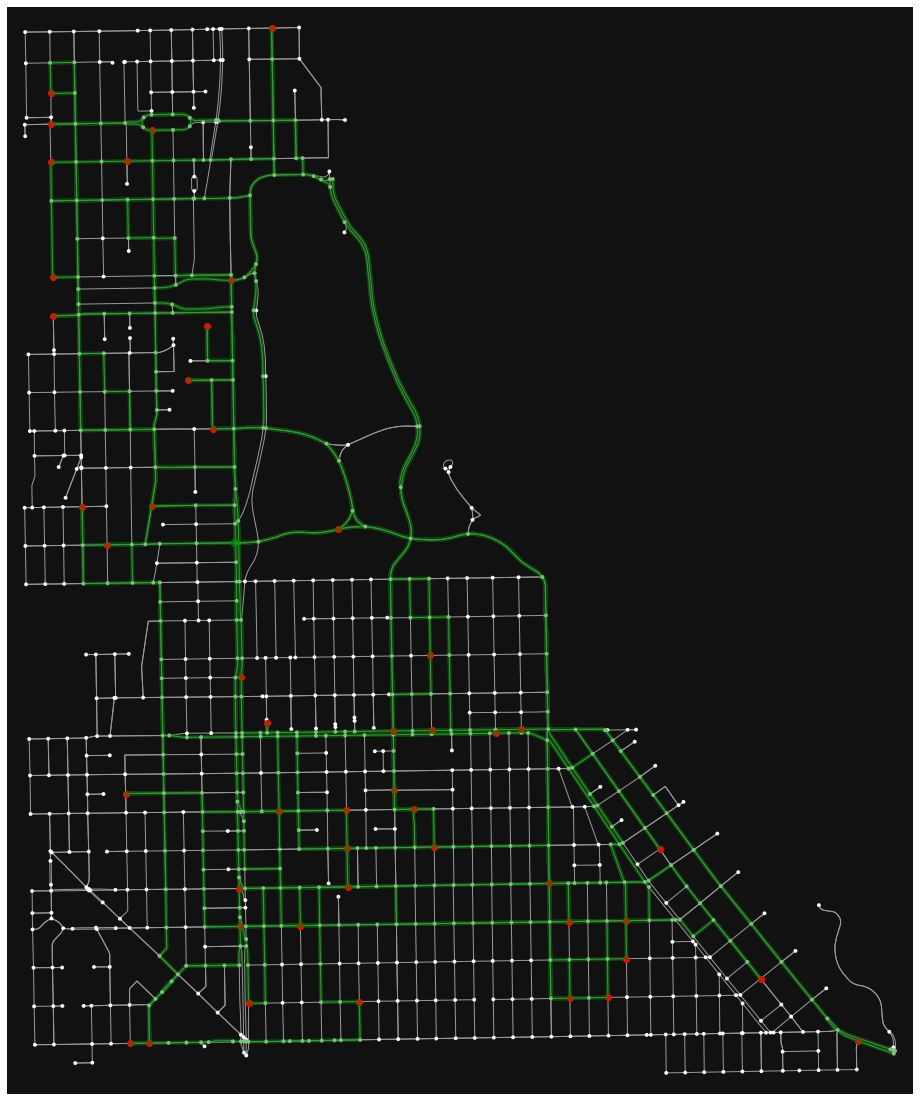

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [250]:
fig,ax = ox.plot_graph(Gox,show=False,close=False,figsize=(20,20))  #plot road network without interactive map component
for point in range(0, len(package_locations)):
    lat = Gox.nodes[package_locations.iloc[point]['Node_num']]['y']
    lon = Gox.nodes[package_locations.iloc[point]['Node_num']]['x']
    ax.scatter(lon,lat, c='red') # add location of packages
ox.plot_graph_route(Gox,tsp_nodes,ax=ax,route_color='green') #graph route

### Spectral Clustering to Segment Network into Regions
Looks at overall road network and segments such that each cluster has a roughly equivalent number of nodes.  Assumption is that each cluster is assigned a vehicle, and each vehicle is responsible for delivering all packages that fall within the cluster

In [254]:
adj_matrix = nx.to_numpy_matrix(Gox)
node_list = list(Gox.nodes())
clusters = cluster.SpectralClustering(affinity='precomputed',assign_labels="discretize",n_clusters=5).fit_predict(adj_matrix)
Gox_gdf["cluster"] = clusters  #add to road network geodataframe


### Look at Distribution of Packages in each Cluster

In [255]:
clustered_packages =pd.merge(package_locations,Gox_gdf,left_on='Node_num',right_on='osmid',how='left')  #find which cluster each package is in by looking at the OSMIDs of the nearest node
clustered_packages[["cluster",'osmid']].groupby("cluster").count() # look at the number of packages that fall into each cluster

,osmid
cluster,
0,10
1,9
2,6
3,15
4,8


### Calculate Route Costs

In [260]:
total_mileage = []
def get_cost(tsp_nodes,vehicle):
    mileage = 0
    for i in range(1,len(tsp_nodes)):
        mileage += nx.shortest_path_length(Gox,tsp_nodes[i-1],tsp_nodes[i],weight='length')/1609.344
    if vehicle=='single':
        return mileage
    else:
        total_mileage.append(mileage)
        print(f"Cost for Package Delivery for Vehicle {vehicle}: ${round(mileage*.625,2)} ({round(mileage,10)} miles)")
routes = []

#for each vehicle, get the cost of delivering their assigned packages
for i in range(0,5):
    node_list = clustered_packages[clustered_packages['cluster']==i]
    node_list = list(node_list['osmid'])
    node_list.insert(0,dist_center['Node_num'].values[0])
    tsp_nodes = approximation.traveling_salesman_problem(Gox,weight='length',nodes=node_list)
    routes.append(tsp_nodes)
    get_cost(tsp_nodes,i)

print(f"\n-------------------------------------------\n")
print(f"Total Cost for Package Delivery for All Vehicles (Multi-Vehicle Approach): ${round(sum(total_mileage)*.625,2)} ({round(sum(total_mileage),3)} miles)")
print(f"\n-------------------------------------------\n")

node_list = list(package_locations['Node_num'])
node_list.insert(0,dist_center['Node_num'].values[0])
tsp_nodes = approximation.traveling_salesman_problem(Gox,weight='length',nodes=node_list)
mileage = get_cost(tsp_nodes,'single')
print(f"Total Cost for Package Delivery (Single Vehicle Approach): ${round(mileage*.625,2)} ({round(mileage,3)} miles)")

print(f"\n-------------------------------------------\n")
print(f"COST SAVINGS FROM MULTIPLE VEHICLES: ${round(mileage*.625-sum(total_mileage)*.625,2)} ({round(mileage-sum(total_mileage),3)} miles)")



Cost for Package Delivery for Vehicle 0: $6.55 (10.4819640798 miles)
Cost for Package Delivery for Vehicle 1: $5.25 (8.4035973664 miles)
Cost for Package Delivery for Vehicle 2: $5.07 (8.1043816611 miles)
Cost for Package Delivery for Vehicle 3: $8.48 (13.5637508202 miles)
Cost for Package Delivery for Vehicle 4: $6.06 (9.7012173904 miles)

-------------------------------------------

Total Cost for Package Delivery for All Vehicles (Multi-Vehicle Approach): $31.41 (50.255 miles)

-------------------------------------------

Total Cost for Package Delivery (Single Vehicle Approach): $54.22 (86.756 miles)

-------------------------------------------

COST SAVINGS FROM MULTIPLE VEHICLES: $22.81 (36.501 miles)


### Plot Routes on Network

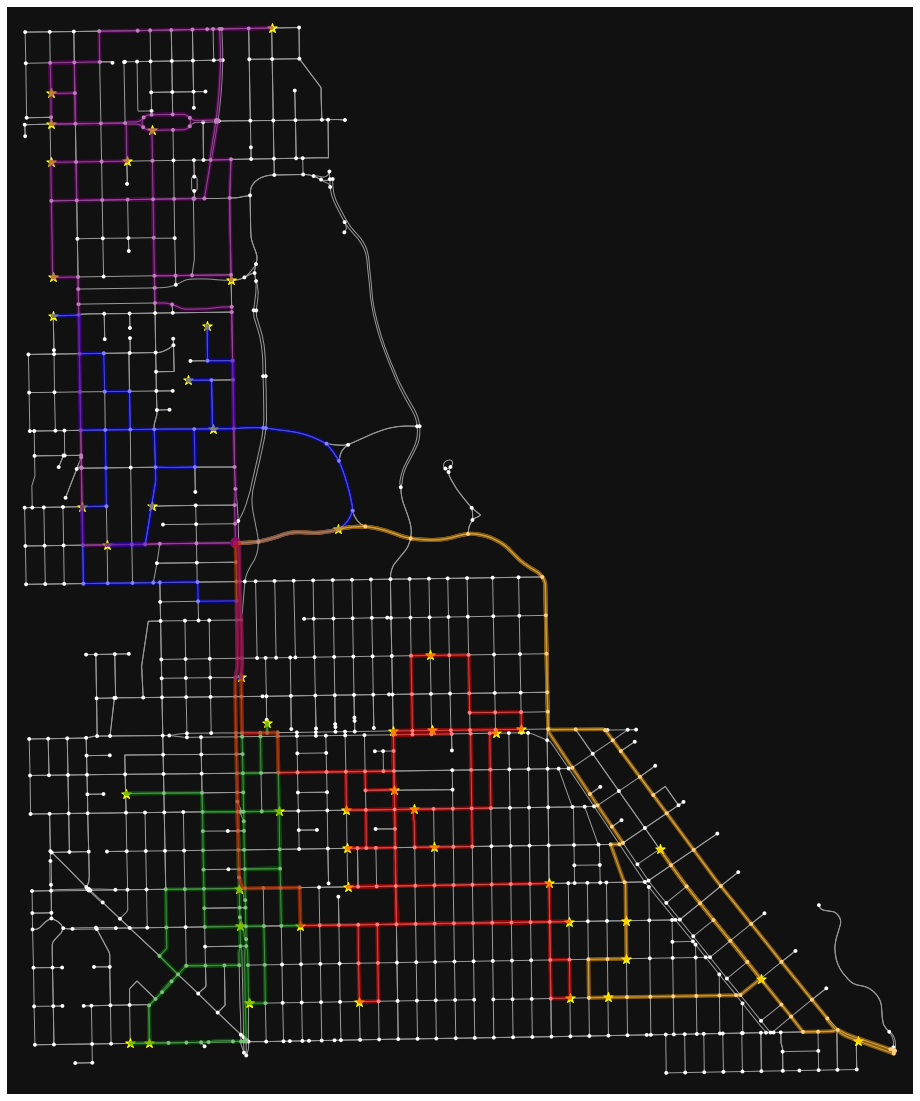

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [257]:
fig,ax = ox.plot_graph(Gox,show=False,close=False,figsize=(20,20))
for point in range(0, len(package_locations)):
    lat = Gox.nodes[package_locations.iloc[point]['Node_num']]['y']
    lon = Gox.nodes[package_locations.iloc[point]['Node_num']]['x']
    ax.scatter(lon,lat, c='yellow',marker="*",s=100)
ox.plot_graph_routes(Gox,routes,ax=ax,route_colors=['green','blue','orange','red','purple'])

### Plot Routes on Map

In [258]:
route_colors=['green','blue','orange','red','purple']

map = ox.plot_route_folium(Gox,routes[0],color=route_colors[0],opacity=0.5)
map = ox.plot_route_folium(Gox, routes[1], route_map=map, color=route_colors[1], opacity=0.5)
map = ox.plot_route_folium(Gox, routes[2], route_map=map, color=route_colors[2], opacity=0.5)
map = ox.plot_route_folium(Gox, routes[3], route_map=map, color=route_colors[3], opacity=0.5)
map = ox.plot_route_folium(Gox, routes[4], route_map=map, color=route_colors[4], opacity=0.5)
def plotDot(point):
    lat = Gox.nodes[point.Node_num]['y']
    lon = Gox.nodes[point.Node_num]['x']
    folium.CircleMarker(location=[lat, lon],radius=2, weight=5,color=route_colors[point.cluster]).add_to(map)
clustered_packages.apply(plotDot,axis=1)
folium.CircleMarker(location=[Gox.nodes[tsp_nodes[0]]['y'],
    Gox.nodes[tsp_nodes[0]]['x']],radius=2,weight=5,color='lightgreen').add_to(map)
map